

# GESTURES: 

### BFRB (Target):
Above ear - Pull hair, Forehead - Pull hairline, Forehead - Scratch, Eyebrow - Pull hair, Eyelash - Pull hair, Neck - Pinch skin, Neck - Scratch, Cheek - Pinch skin

### non-BFRB (non-Target):
Drink from bottle/cup, Glasses on/off, Pull air toward your face, Pinch knee/leg skin, Scratch knee/leg skin, Write name on leg, Text on phone, Feel around in tray and pull out an object, Write name in air, Wave hello


**OBJECTIVE:** classify each subject to determine (1) BFRB-like gesture from non-BFRB-like gesture and (2) the specific type of BFRB-like gesture (type of gesture not important for non-BFRB)

As questions:
(1) Can we separate BFRB from non-BFRB gestures? (easier)
(2) Can we separate BFRB gestures from each other? (harder)

Making the predictions answers both questions.

***
### FOR WRITE UP:

# Sensors & Time-Series Data
Go through the infopages for the IMU, thermophile and time-of-flight sensors and... skim them. Include links and specific details from them to add a layer of depth.

# Other Data
Go through the infopages for the other sensors and... skim them. Include links and specific details from them to add a layer of depth.
- 2 (3?) phases: transition, gesture
- 4 oreintations: lie on back, lie on side, seated lean, seated straight

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import warnings; warnings.filterwarnings("ignore")
from matplotlib.ticker import PercentFormatter
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial.transform import Rotation as R

In [2]:
# custom yellow-orange-bronze color palette
def apply_gold_standard_style(styler):
    styler.background_gradient(cmap='YlOrBr', low=0, high=1, subset=num_cols)
    styler.format('{:.2f}', subset=num_cols)
    styler.set_properties(subset=cat_cols, **{'color': 'black', 'background-color': 'white'})
    styler.set_properties(**{'text-align': 'center', 'font-size': '12px', 'border': '1px solid white'})
    styler.set_table_styles([{'selector': 'th', 'props': [('background-color', '#ffd700'),
        ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('font-size', '14px'),
        ('border', '1px solid white')]}])
    return styler

In [3]:
# load train data
train_placeholder = pd.read_csv("../data/train.csv")
train = train_placeholder.copy()

print(f"Train shape: {train.shape}")
num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(exclude='number').columns
display(train.head().style.pipe(apply_gold_standard_style))

Train shape: (574946, 341)


In [4]:
# load train demographics data
train_demo = pd.read_csv("../data/train_demographics.csv")

print(f"Train Demographics shape: {train_demo.shape}")
num_cols = train_demo.select_dtypes(include='number').columns
cat_cols = train_demo.select_dtypes(exclude='number').columns
display(train_demo.head().style.pipe(apply_gold_standard_style))

Train Demographics shape: (81, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1.00,41.00,1.00,1.00,172.00,50.00,25.00
1,SUBJ_001430,0.00,11.00,0.00,1.00,167.00,51.00,27.00
2,SUBJ_002923,1.00,28.00,1.00,0.00,164.00,54.00,26.00
3,SUBJ_003328,1.00,33.00,1.00,1.00,171.00,52.00,25.00
4,SUBJ_004117,0.00,15.00,0.00,1.00,184.00,54.00,28.00


In [5]:
# load test data
test = pd.read_csv("../data/test.csv")

print(f"Test shape: {test.shape}")
num_cols = test.select_dtypes(include='number').columns
cat_cols = test.select_dtypes(exclude='number').columns
display(test.head().style.pipe(apply_gold_standard_style))

Test shape: (107, 336)


In [6]:
# load test demographics data
test_demo = pd.read_csv("../data/test_demographics.csv")

print(f"Test Demographics shape: {test_demo.shape}")
num_cols = test_demo.select_dtypes(include='number').columns
cat_cols = test_demo.select_dtypes(exclude='number').columns
display(test_demo.head().style.pipe(apply_gold_standard_style))

Test Demographics shape: (2, 8)


,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_016452,1.00,25.00,1.00,1.00,165.00,52.00,23.00
1,SUBJ_055840,0.00,13.00,0.00,1.00,177.00,52.00,27.00


Lots of expository writing here. Take a detour to investigate and somehow address the challenges of this particular problem (righties v. lefties, etc.) 

### ALSO: Subjects 019262 and 045235
These two bozos decided to wear the wrist devices on their heads for the whole study. This data is likely not salvageable, so we'll remove them entirely from the sets.

In [7]:
# remove subjects 019262 and 045235 from train and test datasets
train = train[train['subject'] != 'SUBJ_019262']
train = train[train['subject'] != 'SUBJ_045235']
test = test[test['subject'] != 'SUBJ_019262']
test = test[test['subject'] != 'SUBJ_045235']

### EDA

In [8]:
# drop duplicate rows (if they exist)
print(f"Rows Missing Target Variable: {train["gesture"].isna().sum()}")
print(f"\nShape Before Removing Diplicates: {train.shape}")
train.drop_duplicates(inplace=True)
print(f"Shape After Removing Diplicates: {train.shape}")

Rows Missing Target Variable: 1

Shape Before Removing Diplicates: (562689, 341)
Shape After Removing Diplicates: (562689, 341)


In [9]:
# display example of an IMU sequence
seq_027987 = train[train['sequence_id'] == 'SEQ_027987'].copy()
seq_027987 = seq_027987.drop(["sequence_id", "subject", "orientation", "behavior"], axis=1)
seq_027987 = seq_027987.drop(seq_027987.loc[:, "thm_1" : "tof_5_v63"].columns, axis=1)
num_cols = seq_027987.select_dtypes(include='number').columns
cat_cols = seq_027987.select_dtypes(exclude='number').columns
display(seq_027987.head(52).style.pipe(apply_gold_standard_style))
print(f"Train shape: {train.shape}")

,row_id,sequence_type,sequence_counter,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z
247361,SEQ_027987_000000,Target,0.00,Transition,Cheek - pinch skin,6.09,-0.10,-9.16,0.32,-0.43,-0.83,-0.15
247362,SEQ_027987_000001,Target,1.00,Transition,Cheek - pinch skin,5.05,0.24,-9.62,0.23,-0.50,-0.81,-0.20
247363,SEQ_027987_000002,Target,2.00,Transition,Cheek - pinch skin,5.78,1.81,-7.21,0.12,-0.64,-0.67,-0.36
247364,SEQ_027987_000003,Target,3.00,Transition,Cheek - pinch skin,6.35,2.73,-4.18,0.03,-0.73,-0.46,-0.51
247365,SEQ_027987_000004,Target,4.00,Transition,Cheek - pinch skin,8.99,1.89,-3.04,0.03,0.77,0.25,0.58
247366,SEQ_027987_000005,Target,5.00,Transition,Cheek - pinch skin,10.18,1.20,-1.39,0.07,0.78,0.08,0.62
247367,SEQ_027987_000006,Target,6.00,Transition,Cheek - pinch skin,9.27,1.36,-1.08,0.10,0.76,0.03,0.64
247368,SEQ_027987_000007,Target,7.00,Transition,Cheek - pinch skin,10.22,1.66,-1.16,0.10,0.75,0.03,0.65
247369,SEQ_027987_000008,Target,8.00,Transition,Cheek - pinch skin,9.65,1.62,-1.50,0.10,0.76,0.03,0.65
247370,SEQ_027987_000009,Target,9.00,Transition,Cheek - pinch skin,9.57,1.62,-1.39,0.10,0.76,0.03,0.65


Train shape: (562689, 341)


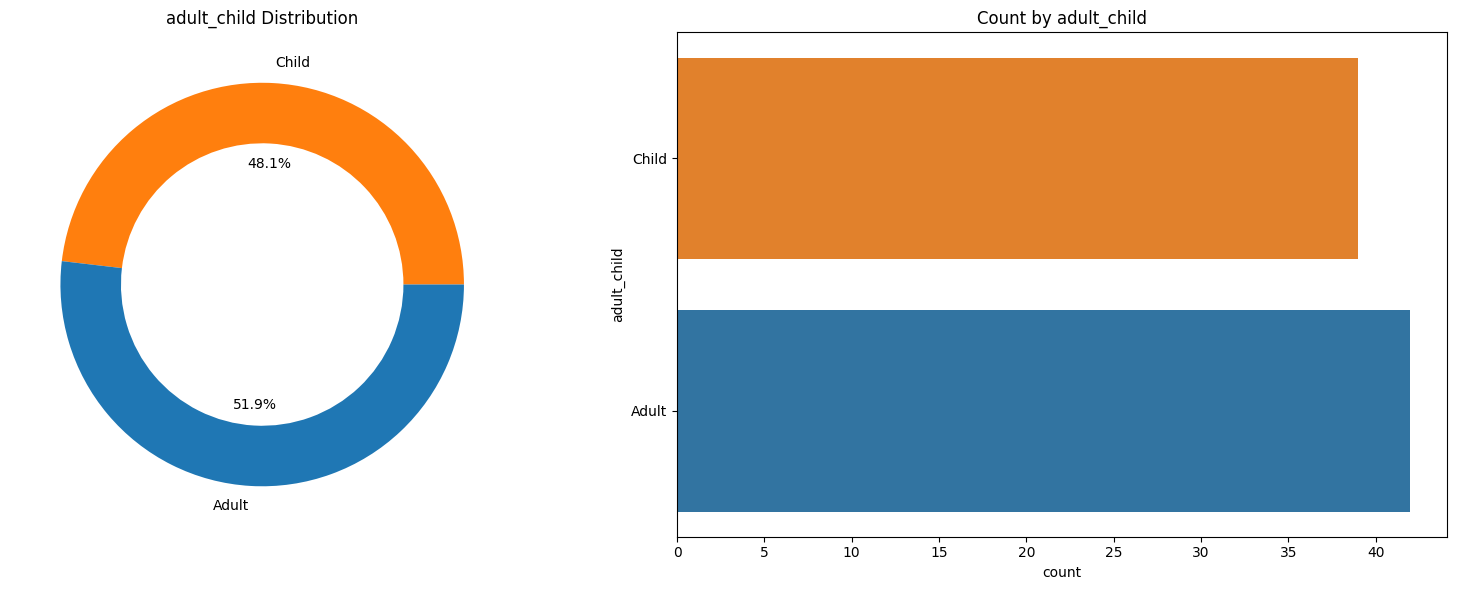

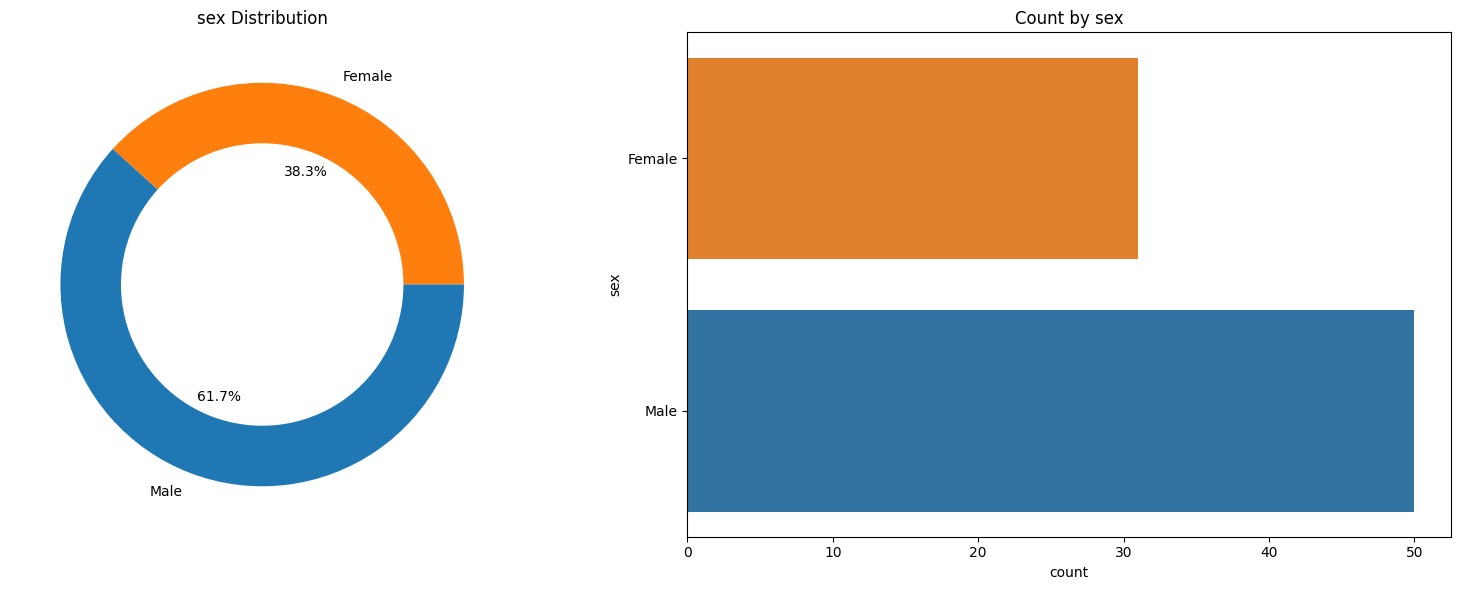

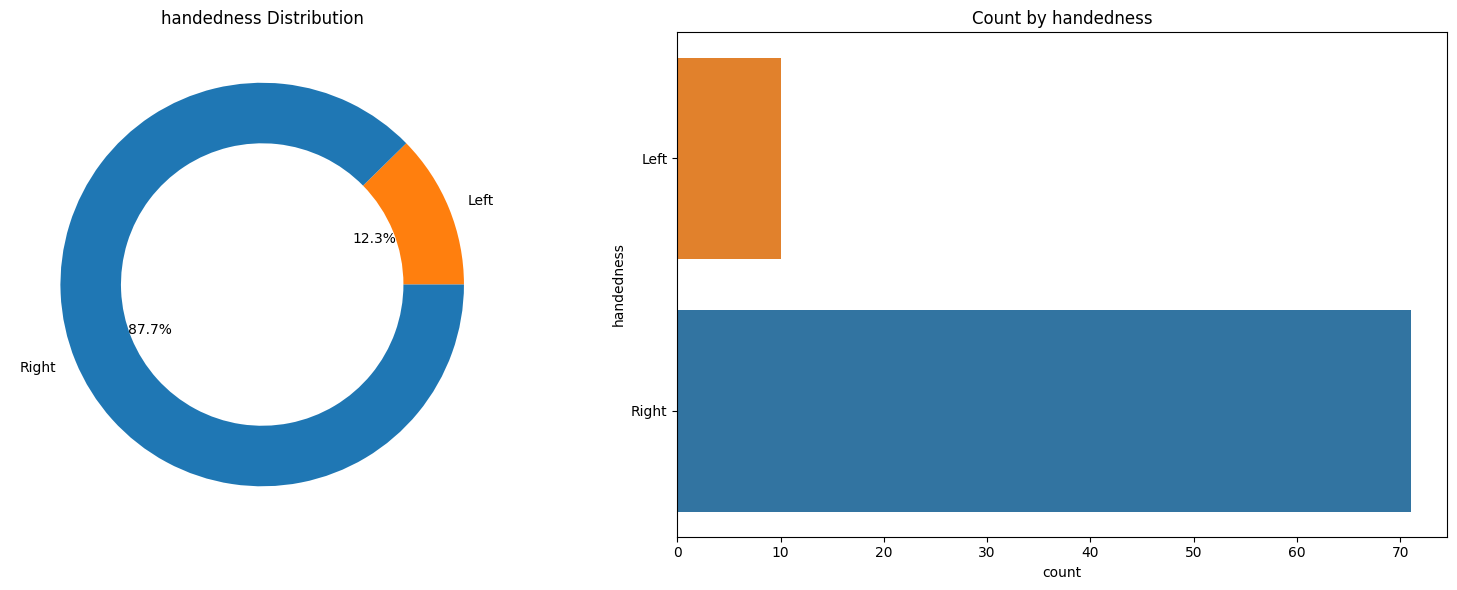

Train shape: (562689, 341)


In [10]:
# Categorical variables to analyze with their respective value mappings
categorical_variables = ["adult_child", "sex", "handedness"]
value_mappings = {"adult_child": {0: "Child", 1: "Adult"}, "sex": {0: "Female", 1: "Male"}, "handedness": {0: "Left", 1: "Right"}}

# define plotting function for categorical variables
def plot_categorical(variable, data, value_mapping=None):

    colors = {0: '#ff7f0e', 1: '#1f77b4'}
    plt.figure(figsize=(16, 6))
    
    # get value counts and sort by index
    value_counts = data[variable].value_counts().sort_index()
    
    # create labels using the mapping if available, otherwise use original values
    labels = [value_mapping.get(i, str(i)) for i in value_counts.index]
    
    # pie chart
    plt.subplot(1, 2, 1)
    plt.pie(value_counts, autopct='%1.1f%%', colors=[colors.get(i, '#2ca02c') for i in value_counts.index], wedgeprops=dict(width=0.3), labels=labels)
    plt.title(f"{variable} Distribution")
    
    # countplot
    plt.subplot(1, 2, 2)
    ax = sns.countplot(data=data, y=variable, order=value_counts.index, palette=[colors.get(i, '#2ca02c') for i in value_counts.index])
    
    # update y-tick labels
    ax.set_yticklabels(labels)
    plt.title(f"Count by {variable}")
    plt.tight_layout()
    plt.show()

# generate plots for each categorical variable
for var in categorical_variables:
    if var in train_demo.columns:
        plot_categorical(variable=var, data=train_demo, value_mapping=value_mappings.get(var))
print(f"Train shape: {train.shape}")

Train shape: (562689, 341)


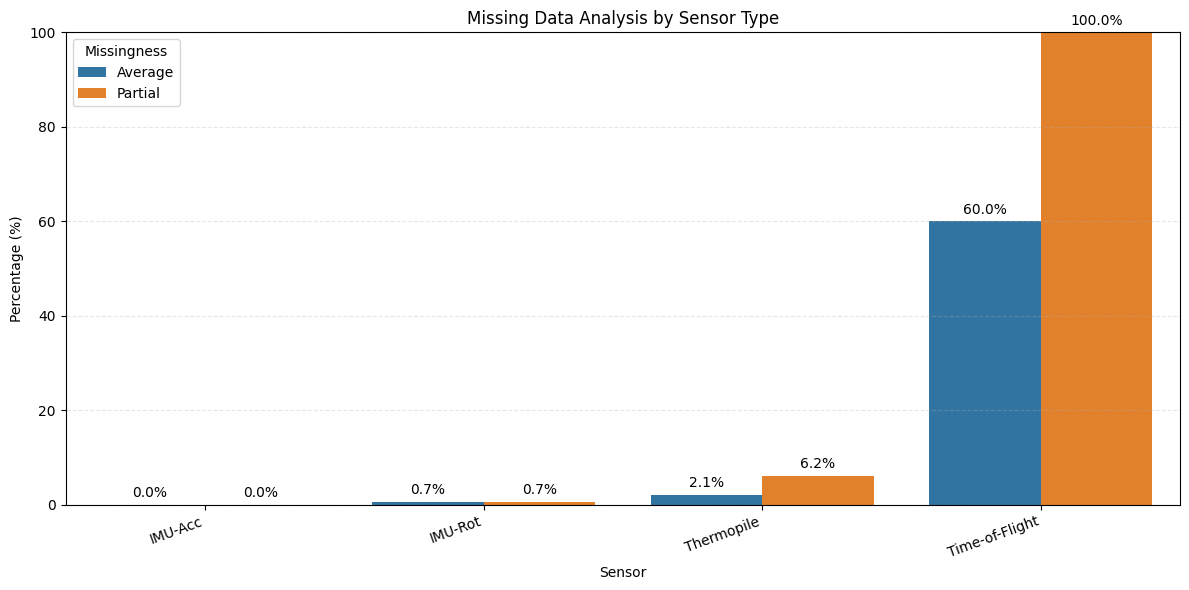

In [11]:
# MISSING DATA ANALYSIS

# replace -1 and 0 in time-of-flight data with NaN in train and test
train.iloc[:, 21:] = train.iloc[:, 21:].replace([-1, 0], np.nan)
test.iloc[:, 14:] = test.iloc[:, 14:].replace([-1, 0], np.nan)

# define sensor groups
sensor_groups = {'IMU-Acc': [c for c in train if c.startswith('acc_')], 'IMU-Rot': [c for c in train if c.startswith('rot_')], 'Thermopile': [c for c in train if c.startswith('thm_')],
    'Time-of-Flight': [c for c in train if c.startswith('tof_')]}

# calculate metrics
metrics = []
for name, cols in sensor_groups.items():
    missing = train[cols].isnull()
    metrics.extend([{'Sensor': name, 'Type': 'Average', '%': missing.mean().mean() * 100}, {'Sensor': name, 'Type': 'Partial', '%': missing.any(axis=1).mean() * 100}])

# generate bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=pd.DataFrame(metrics), x='Sensor', y='%', hue='Type', palette={'Average': '#1f77b4', 'Partial': '#ff7f0e'})

# add percentage labels
for p in plt.gca().patches:
    if (h := p.get_height()) > 0:
        plt.text(p.get_x() + p.get_width()/2, h + 1, f'{h:.1f}%', ha='center', va='bottom')

plt.title('Missing Data Analysis by Sensor Type')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Missingness')
plt.tight_layout()

print(f"Train shape: {train.shape}")

Give an intuitive explanation for why it makes sense to replace missing ToF data with a large integer like 400.

In [12]:
# display missing values before imputation
print("Before imputation:")
display(train.isna().sum())

# impute missing rot values with 0
rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
train[rots] = train[rots].fillna(0)

# fill missing temperature data with average by column
thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
imputer = SimpleImputer(strategy='constant', fill_value=0)
train[thms] = imputer.fit_transform(train[thms])

# fill all NaNs in time-of-flight (ToF) columns with 400
tof_train = train.loc[:, "tof_1_v0" : "tof_5_v63"].columns
train[tof_train] = train[tof_train].fillna(400)
tof_test = test.loc[:, "tof_1_v0" : "tof_5_v63"].columns
test[tof_test] = test[tof_test].fillna(400)

# display missing values after imputation
print("After imputation:")
display(train.isna().sum())

Before imputation:


row_id                   1
sequence_type            1
sequence_id              1
sequence_counter         0
subject                  1
                     ...  
tof_5_v59           369980
tof_5_v60           381416
tof_5_v61           392929
tof_5_v62           405754
tof_5_v63           416508
Length: 341, dtype: int64

After imputation:


row_id              1
sequence_type       1
sequence_id         1
sequence_counter    0
subject             1
                   ..
tof_5_v59           0
tof_5_v60           0
tof_5_v61           0
tof_5_v62           0
tof_5_v63           0
Length: 341, dtype: int64

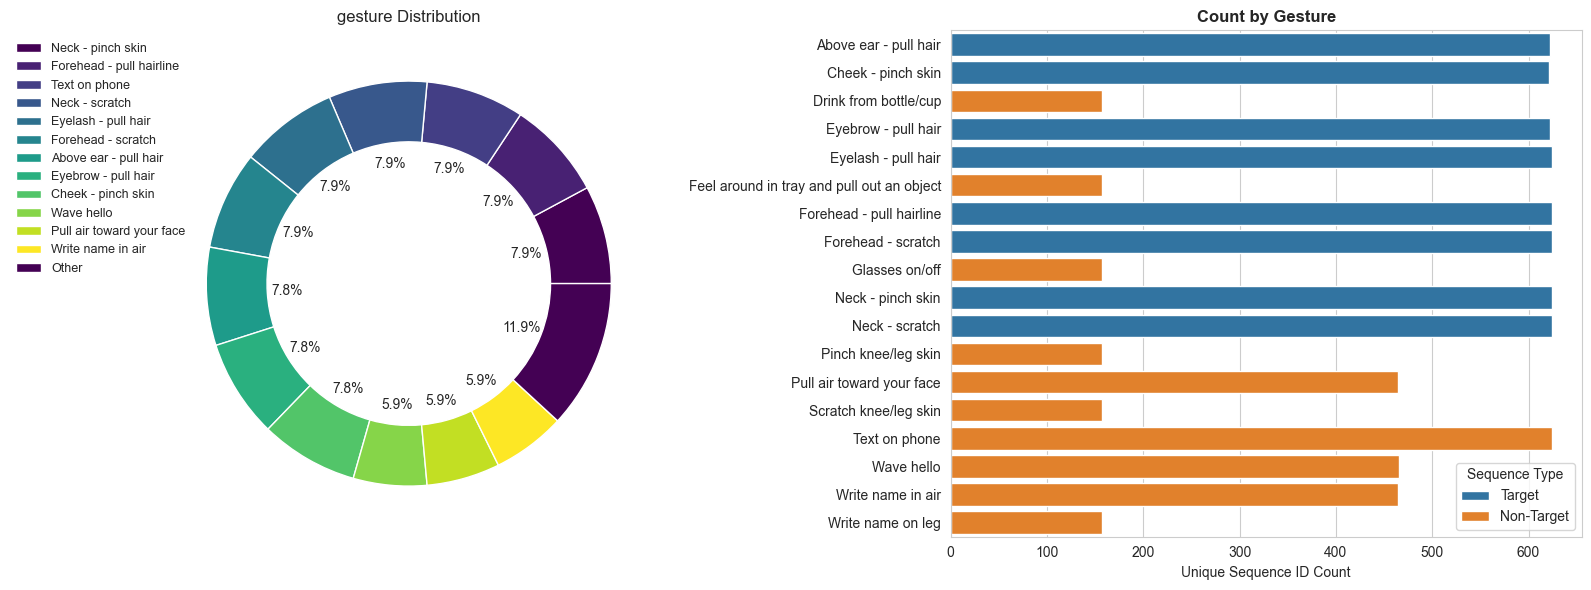

In [13]:
# generate color palette for gesture distribution chart
palette = [to_hex(viridis(i / 11)) for i in range(12)]

# generate charts
def plot_gesture_distribution(data, variable='gesture', source_name="Target Variable"):
    sns.set_style('whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # gesture distribution chart
    value_counts = data.groupby(variable)['sequence_id'].nunique().sort_values(ascending=False)
    filtered = value_counts[value_counts >= 0.05 * value_counts.sum()]
    if (other := value_counts.sum() - filtered.sum()) > 0:
        filtered['Other'] = other
    ax1.pie(filtered, autopct='%1.1f%%', colors=palette[:len(filtered)], wedgeprops={'width': 0.3})
    ax1.legend(filtered.index, bbox_to_anchor=(-0.3, 1), loc='upper left', prop={'size': 9}, frameon=False, borderpad=0.5, labelspacing=0.5)
    ax1.set_title(f"{variable} Distribution")

    # gesture count chart
    group_df = data.groupby([variable, 'sequence_type'])['sequence_id'].nunique().reset_index()
    sns.barplot(data=group_df, y=variable, x='sequence_id', hue='sequence_type', palette=['#1f77b4', '#ff7f0e'], ax=ax2)
    ax2.set(xlabel='Unique Sequence ID Count', ylabel='')
    ax2.legend(title='Sequence Type')
    ax2.set_title("Count by Gesture", fontweight='bold')
    plt.tight_layout()
plot_gesture_distribution(train)

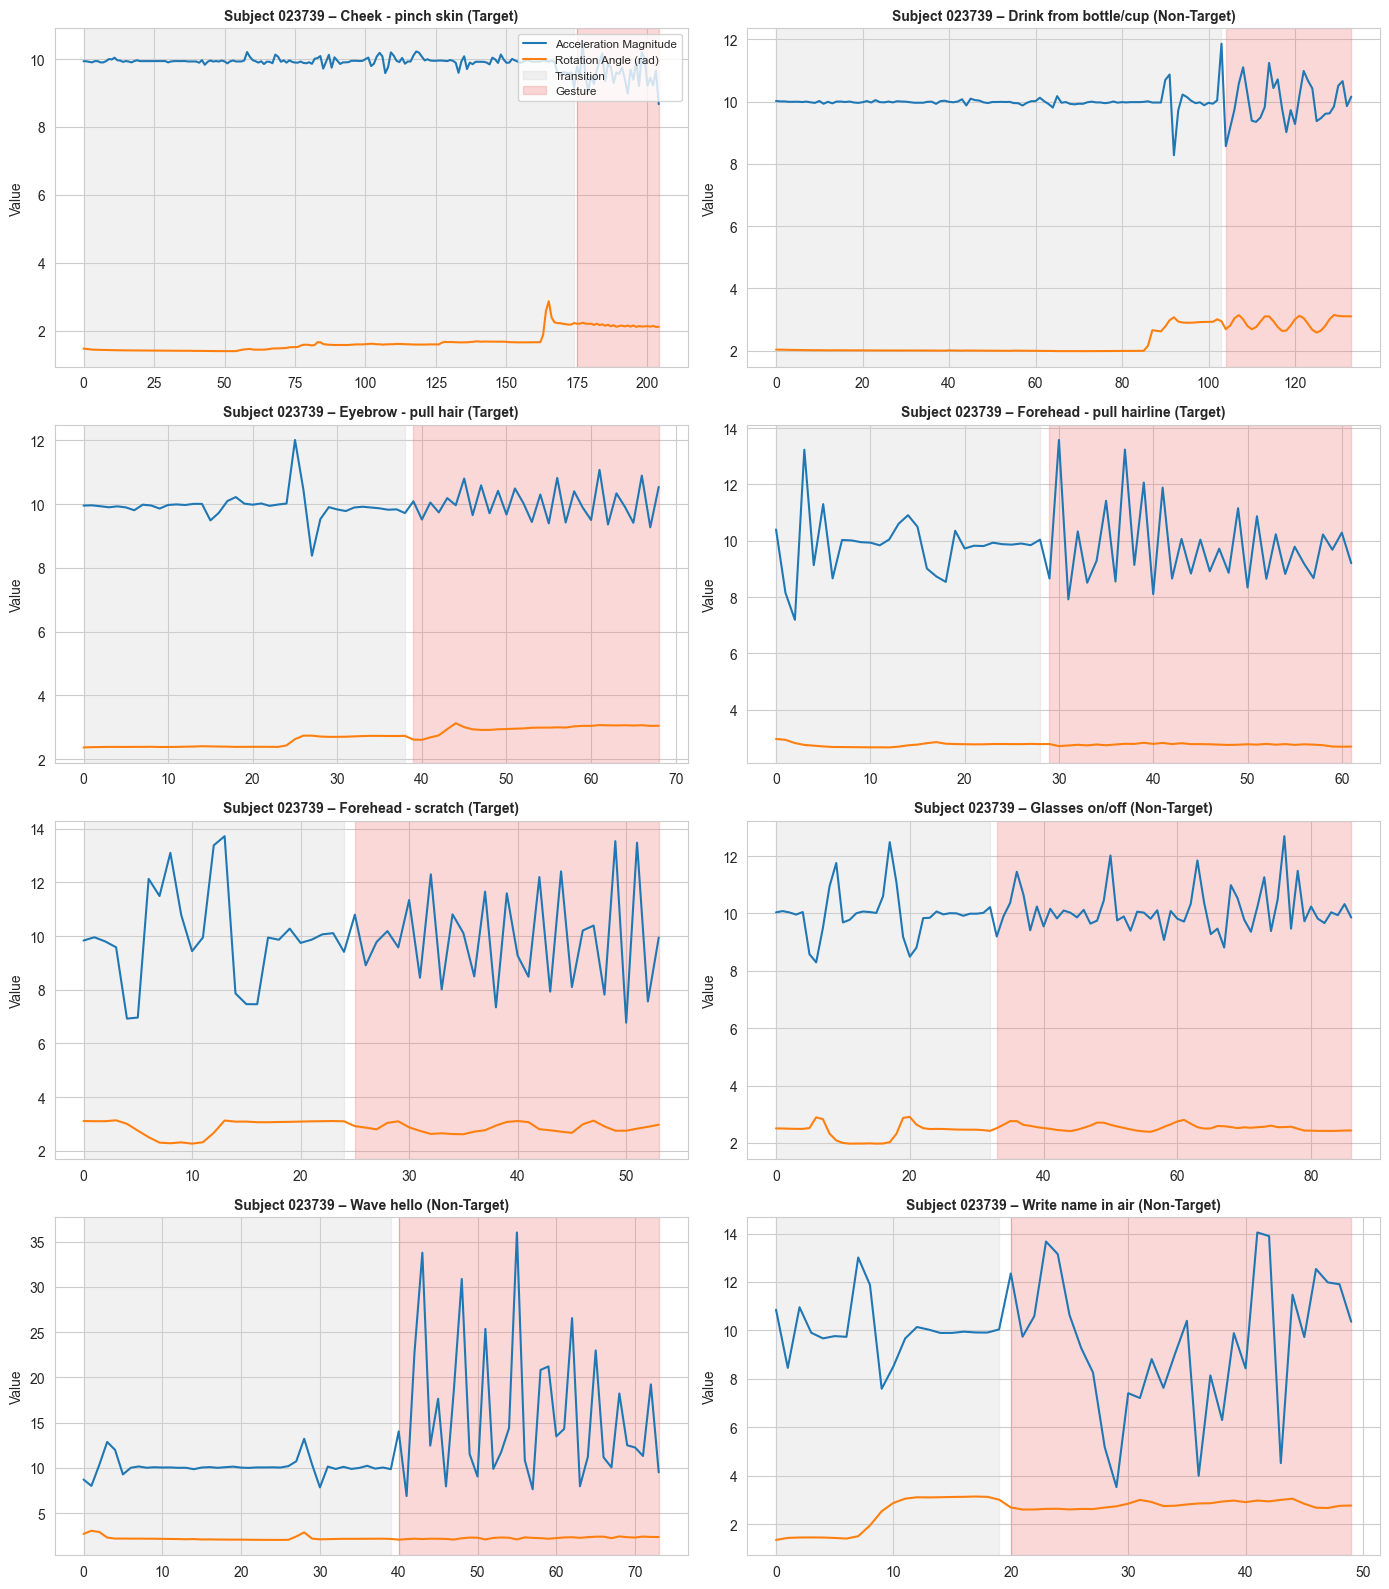

In [14]:
# GESTURE SAMPLE ANALYSIS FROM SUBJECT 023739

# compute features
subj_023739 = train[train['subject'] == 'SUBJ_023739'].copy()
subj_023739['acc_mag'] = np.sqrt(subj_023739[['acc_x', 'acc_y', 'acc_z']].pow(2).sum(axis=1))
subj_023739['rot_angle'] = 2 * np.arccos(subj_023739['rot_w'].clip(-1, 1))

# get one sequence per gesture
selected_gestures = ["Cheek - pinch skin", "Drink from bottle/cup", "Eyebrow - pull hair", "Forehead - pull hairline", "Forehead - scratch", "Glasses on/off", "Wave hello", "Write name in air"]
seq_ids = subj_023739[subj_023739['gesture'].isin(selected_gestures)].groupby('gesture')['sequence_id'].first().values

# setup figure
n = len(seq_ids)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), squeeze=False)
axes = axes.flatten()

# plot data
for i, seq in enumerate(seq_ids):
    ax = axes[i]
    df = subj_023739[subj_023739['sequence_id'] == seq].sort_values('sequence_counter')
    times = df['sequence_counter']
    ax.plot(times, df['acc_mag'], label='Acceleration Magnitude', color='tab:blue')
    ax.plot(times, df['rot_angle'], label='Rotation Angle (rad)', color='tab:orange')
    
    # add phase shading
    for phase, color in [('Transition', 'lightgray'), ('Gesture', 'lightcoral')]:
        mask = df['phase'] == phase
        if not mask.any(): continue
        idxs = np.where(mask)[0]
        for start, end in zip(np.concatenate(([0], np.where(np.diff(idxs) > 1)[0] + 1)), np.concatenate((np.where(np.diff(idxs) > 1)[0], [len(idxs)-1]))):
            t0, t1 = df.iloc[idxs[start]]['sequence_counter'], df.iloc[idxs[end]]['sequence_counter']
            ax.axvspan(t0, t1, color=color, alpha=0.3, label=phase if phase not in ax.get_legend_handles_labels()[1] else None)
    
    # format subplot
    ax.set_title(f"Subject 023739 – {df['gesture'].iloc[0]} ({df['sequence_type'].iloc[0]})", fontsize=10, fontweight='bold')
    ax.set(xlabel="", ylabel="Value")
    ax.legend(loc='upper right', fontsize='small').set_visible(i == 0)  # Only show legend for first plot
    ax.grid(True)

# clean up and show
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

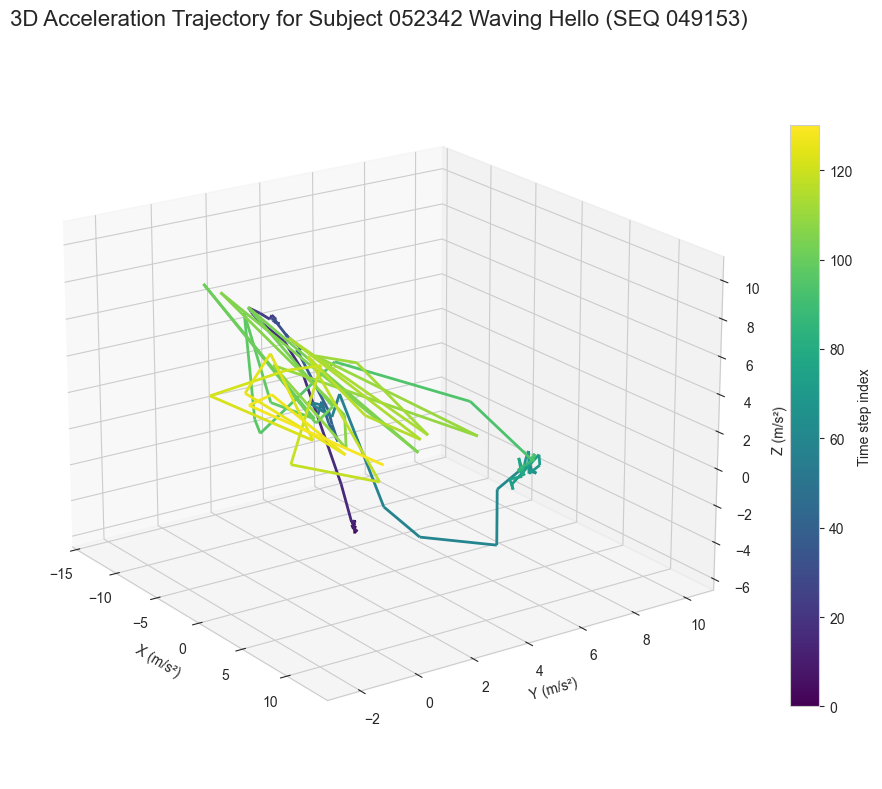

In [15]:
# 3D RENDERING OF ACCELERATION TRAJECTORY FOR SUBJECT 052342 WAVING "HELLO"

seq_049153 = train[train['sequence_id'] == 'SEQ_049153'].copy()
x_data = seq_049153['acc_x'].values
y_data = seq_049153['acc_y'].values
z_data = seq_049153['acc_z'].values

# plot 3D trajectory
def plot_3d_trajectory(x, y, z, title="3D Trajectory"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    time_steps = np.arange(len(x))
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = plt.get_cmap('viridis')
    lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    lc.set_array(time_steps)
    lc.set_linewidth(2)
    ax.add_collection3d(lc)

    # add a color bar
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.set_label('Time step index')

    # customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X (m/s²)')
    ax.set_ylabel('Y (m/s²)')
    ax.set_zlabel('Z (m/s²)')

    # final details
    buffer = 1.5
    ax.set_xlim(x.min() - buffer, x.max() + buffer)
    ax.set_ylim(y.min() - buffer, y.max() + buffer)
    ax.set_zlim(z.min() - buffer, z.max() + buffer)
    ax.view_init(elev=20., azim=-35)
    ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_3d_trajectory(x_data, y_data, z_data, title="3D Acceleration Trajectory for Subject 052342 Waving Hello (SEQ 049153)")

In [16]:
# filter out short gesture sequences (bad data)
gesture_counts = ((train['phase'] == 'Gesture').groupby(train['sequence_id']).transform('sum'))
train = train[gesture_counts >= 15].reset_index(drop=True)
print(train.shape)

(560044, 341)


### Pre-process left hand to match right hand

Identify the lefties in the train set and apply a coordinate system transformation so they match the right hand. This is supposedly only necessary for accelaration and orientation, not time-of-flight or thermophile. (I pinned a gemini chat for how to program this)

Left handed subjects: 002923, 013623, 019756, 028998, 032233, 032585, 039234, 041243, 055211, 061552

In [17]:
# STANDARDIZE LEFT HAND TO MATCH RIGHT HAND

lefties = ["SUBJ_002923", "SUBJ_013623", "SUBJ_019756", "SUBJ_028998", "SUBJ_032233", "SUBJ_032585", "SUBJ_039234", "SUBJ_041243", "SUBJ_055211", "SUBJ_061552"]
lefty_mask = train.subject.isin(lefties)

# transform acceleration data
train.loc[lefty_mask, 'acc_y'] = -train.loc[lefty_mask, 'acc_y']
train.loc[lefty_mask, 'acc_z'] = -train.loc[lefty_mask, 'acc_z']

# transform orientation data
q_original = train.loc[lefty_mask, ['rot_w', 'rot_x', 'rot_y', 'rot_z']].copy()
train.loc[lefty_mask, 'rot_w'] = -q_original['rot_x']
train.loc[lefty_mask, 'rot_x'] =  q_original['rot_w']
train.loc[lefty_mask, 'rot_y'] = -q_original['rot_z']
train.loc[lefty_mask, 'rot_z'] =  q_original['rot_y']

### Convert from local to global frame

Explain what exactly this step is and why it is so important. It's a pretty intuitive idea and should make sense to the reader. (I pinned a gemini chat on how to program this)

In [18]:
# CONVERT LOCAL FRAME TO GLOBAL FRAME

# function to convert local frame to global frame
def to_global(dataset):
    local_acc = dataset[['acc_x', 'acc_y', 'acc_z']].to_numpy(dtype=float)
    q_xyzw = dataset[['rot_x', 'rot_y', 'rot_z', 'rot_w']].to_numpy(dtype=float)
    norm = np.linalg.norm(q_xyzw, axis=1)
    valid = np.isfinite(norm) & (norm > 0)
    q_unit = np.full_like(q_xyzw, np.nan)
    q_unit[valid] = q_xyzw[valid] / norm[valid, None]

    # apply rotation only on valid rows, then write results back into train
    rot = R.from_quat(q_unit[valid])
    acc_global_valid = rot.apply(local_acc[valid])
    acc_global = np.full((len(dataset), 3), np.nan)
    acc_global[valid] = acc_global_valid
    dataset[['acc_x', 'acc_y', 'acc_z']] = acc_global
    return dataset

to_global(train);
to_global(test);

In [19]:
# linear interpolation for missing acceleration data
acc_cols = ["acc_x", "acc_y", "acc_z"]
train[acc_cols] = train[acc_cols].interpolate(method='linear', limit_direction='both')
print(train.isna().sum())

row_id              0
sequence_type       0
sequence_id         0
sequence_counter    0
subject             0
                   ..
tof_5_v59           0
tof_5_v60           0
tof_5_v61           0
tof_5_v62           0
tof_5_v63           0
Length: 341, dtype: int64


For write-up: stress that orientation and movement inform one another.

In [20]:
import random

# create validation set
sequences = train['sequence_id'].unique().tolist()
val_sequences = random.sample(sequences, int(len(sequences) * 0.2))
validation = train[train['sequence_id'].isin(val_sequences)].copy()
train = train[~train['sequence_id'].isin(val_sequences)].reset_index(drop=True)

In [21]:
# define irrelevant columns
columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']

# remove irrelevant columns from train, test and validation sets (leaving backup validation for evaluation)
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

# create set list
sets = [train, test, validation]

### Feature Engineering/ Pre-Processing

Features to create:
- lin_acc_x
- lin_acc_y
- lin_acc_z
- acc_mag
- lin_acc_mag
- acc_mag_jerk
- lin_acc_mag_jerk
- rot_angle
- angular_distance
- rot_angle_vel
- angular_vel_x
- angular_vel_y
- angular_vel_z

Jerk: derivative of acceleration

In [22]:
# GENERATE LINEAR ACCELERATION FEATURE (ACCELERATION WITHOUT GRAVITY)

# function to remove gravity from acceleration
def remove_gravity_from_acc(acc_data, rot_data):
    if isinstance(acc_data, pd.DataFrame):
        acc_values = acc_data[['acc_x', 'acc_y', 'acc_z']].values
    else:
        acc_values = acc_data

    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data
    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)
    
    # gravity in world frame (m/s²)
    gravity_world = np.array([0, 0, 9.81])

    for i in range(num_samples):
        if np.all(np.isnan(quat_values[i])) or np.all(np.isclose(quat_values[i], 0)):
            linear_accel[i, :] = acc_values[i, :] 
            continue
        try:
            q = quat_values[i]
            norm = np.linalg.norm(q)
            if norm == 0:
                linear_accel[i, :] = acc_values[i, :]
                continue
            q_normalized = q / norm
            rotation = R.from_quat(q_normalized)
            gravity_sensor_frame = rotation.apply(gravity_world, inverse=False)
            linear_accel[i, :] = acc_values[i, :] - gravity_sensor_frame
        except Exception as e:
            print(f"Error at index {i}: {e}")
            print(f"Problematic quaternion: {q}")
            linear_accel[i, :] = np.nan
    return linear_accel

# apply function to each dataset
for dataset in sets:
    if 'lin_acc_x' not in dataset.columns:
        dataset[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']] = np.nan
    for seq_id, group in dataset.groupby('sequence_id'):
        linear_accel = remove_gravity_from_acc(group[['acc_x', 'acc_y', 'acc_z']], group[['rot_x', 'rot_y', 'rot_z', 'rot_w']])
        dataset.loc[group.index, ['lin_acc_x', 'lin_acc_y', 'lin_acc_z']] = linear_accel

# verify the results for "train"
print("For Train:")
print("Original acceleration sample:", train[['acc_x', 'acc_y', 'acc_z']].iloc[0].values)
print("Linear acceleration sample:", train[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].iloc[0].values)

For Train:
Original acceleration sample: [ 0.09802218 -0.08301941  9.72303339]
Linear acceleration sample: [-4.36499981 -8.1263476   6.31386833]


In [23]:
# GENERATE MAGNITUDE FEATURES

# acc_mag
train['acc_mag'] = np.sqrt(train['acc_x']**2 + train['acc_y']**2 + train['acc_z']**2)
validation['acc_mag'] = np.sqrt(validation['acc_x']**2 + validation['acc_y']**2 + validation['acc_z']**2)
test['acc_mag'] = np.sqrt(test['acc_x']**2 + test['acc_y']**2 + test['acc_z']**2)

# lin_acc_mag
train['lin_acc_mag'] = np.sqrt(train['lin_acc_x']**2 + train['lin_acc_y']**2 + train['lin_acc_z']**2)
validation['lin_acc_mag'] = np.sqrt(validation['lin_acc_x']**2 + validation['lin_acc_y']**2 + validation['lin_acc_z']**2)
test['lin_acc_mag'] = np.sqrt(test['lin_acc_x']**2 + test['lin_acc_y']**2 + test['lin_acc_z']**2)

In [24]:
# GENERATE JERK FEATURES

def calculate_jerk(acc_mag, time_step=0.1):
    return np.gradient(acc_mag, time_step)

def process_sequences(dataset, mag_column, jerk_column):
    if jerk_column not in dataset.columns:
        dataset[jerk_column] = np.nan
    for seq_id, group in dataset.groupby('sequence_id'):
        if mag_column in group.columns:
            try:
                jerk = calculate_jerk(group[mag_column])
                dataset.loc[group.index, jerk_column] = jerk
            except Exception as e:
                print(f"Error processing sequence {seq_id}: {e}")

# generate jerk features for all datasets
for dataset in sets:
    process_sequences(dataset, 'acc_mag', 'acc_mag_jerk')
    if 'lin_acc_mag' in dataset.columns:
        process_sequences(dataset, 'lin_acc_mag', 'lin_acc_mag_jerk')
    process_sequences(dataset, 'acc_mag', 'acc_mag_jerk')
    if 'lin_acc_mag' in dataset.columns:
        process_sequences(dataset, 'lin_acc_mag', 'lin_acc_mag_jerk')

Also explain what "rotation angle" is. Talk about the relationship between rotation angle, rotation angle velocity, and angular distance.

In [25]:
# CALCULATE ROTATION ANGLE
train['rot_angle'] = 2 * np.arccos(train['rot_w'].clip(-1, 1))
validation['rot_angle'] = 2 * np.arccos(validation['rot_w'].clip(-1, 1))
test['rot_angle'] = 2 * np.arccos(test['rot_w'].clip(-1, 1))

In [26]:
# CALCULATE ANGULAR DISTANCE AND ROTATION ANGLE VELOCITY

# quaternion multiplication
def q_mult(q1, q2):
    x1, y1, z1, w1 = q1
    x2, y2, z2, w2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return np.array([x, y, z, w])

# angular distance
def calculate_angular_distance_for_sequence(seq_df):
    q_cols = ['rot_x', 'rot_y', 'rot_z', 'rot_w']
    q_prev = seq_df[q_cols].shift(1).values
    q_curr = seq_df[q_cols].values
    rot_angle_dist = [np.nan]
    for i in range(1, len(seq_df)):
        q1 = q_prev[i]
        q2 = q_curr[i]
        q1_conj = np.array([-q1[0], -q1[1], -q1[2], q1[3]])
        delta_q = q_mult(q2, q1_conj)
        delta_w = np.clip(delta_q[3], -1.0, 1.0)
        angle = 2 * np.arccos(delta_w)  # radians
        rot_angle_dist.append(angle)
    return pd.Series(rot_angle_dist, index=seq_df.index)

# add angular distance to train, test, and validation
rot_angle_dist_train = (train.groupby('sequence_id', group_keys=False).apply(calculate_angular_distance_for_sequence))
train['angular_distance'] = rot_angle_dist_train.reindex(train.index).fillna(0)
rot_angle_dist_test = (test.groupby('sequence_id', group_keys=False).apply(calculate_angular_distance_for_sequence))
test['angular_distance'] = rot_angle_dist_test.reindex(test.index).fillna(0)
rot_angle_dist_val = (validation.groupby('sequence_id', group_keys=False).apply(calculate_angular_distance_for_sequence))
validation['angular_distance'] = rot_angle_dist_val.reindex(validation.index).fillna(0)

# add rotation angle velocity to train, test, and validation
train['rot_angle_vel'] = train['angular_distance']*0.1
test['rot_angle_vel'] = test['angular_distance']*0.1
validation['rot_angle_vel'] = validation['angular_distance']*0.1

In [27]:
# CALCULATE ANGULAR VELOCITY X/ Y/ Z

# define function to compute angular velocity
def compute_angular_velocity_xyz_for_sequence(seq_df, dt=0.1):
    q_cols = ['rot_x', 'rot_y', 'rot_z', 'rot_w']
    q = seq_df[q_cols].to_numpy(dtype=float)

    # normalize quaternions
    norms = np.linalg.norm(q, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    q = q / norms
    n = len(seq_df)
    wx = np.zeros(n, dtype=float)
    wy = np.zeros(n, dtype=float)
    wz = np.zeros(n, dtype=float)
    for i in range(1, n):
        q_prev = q[i - 1]
        q_curr = q[i]
        if np.dot(q_curr, q_prev) < 0.0:
            q_curr = -q_curr
        q_prev_conj = np.array([-q_prev[0], -q_prev[1], -q_prev[2], q_prev[3]], dtype=float)
        delta = q_mult(q_curr, q_prev_conj)

        # normalize delta quaternion
        dnorm = np.linalg.norm(delta)
        if dnorm != 0:
            delta = delta / dnorm
        v = delta[:3]
        w = delta[3]
        norm_v = np.linalg.norm(v)
        if norm_v < 1e-12:
            omega = (2.0 / dt) * v
        else:
            angle = 2.0 * np.arctan2(norm_v, w)
            axis = v / norm_v
            omega = (angle / dt) * axis
        wx[i], wy[i], wz[i] = omega
    return pd.DataFrame({'angular_vel_x': wx, 'angular_vel_y': wy, 'angular_vel_z': wz}, index=seq_df.index)

# train
vel_train = train.groupby('sequence_id', group_keys=False).apply(compute_angular_velocity_xyz_for_sequence, dt=0.1)
train[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = vel_train.reindex(train.index)

# test
vel_test = test.groupby('sequence_id', group_keys=False).apply(compute_angular_velocity_xyz_for_sequence, dt=0.1)
test[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = vel_test.reindex(test.index)

# validation
vel_validation = validation.groupby('sequence_id', group_keys=False).apply(compute_angular_velocity_xyz_for_sequence, dt=0.1)
validation[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = vel_validation.reindex(validation.index)

In [28]:
# move created features to the back of the dataset
# train and validation
new_features = train.columns[334:].tolist()
other_columns = [col for col in train.columns if col not in new_features]
new_cols = other_columns[:2] + new_features + other_columns[2:]
train = train[new_cols]
validation = validation[new_cols]

# test
other_columns = [col for col in test.columns if col not in new_features]
new_cols = other_columns[:1] + new_features + other_columns[1:]
test = test[new_cols]


## FEATURE SCALING
Feature scaling is the process of transforming the numerical features of your data into a common scale. The idea is to strip away the original units and magintude of a feature, and instead represent its values based on their position relative to the other values in that same feature. You could accomplish this using various statistical methods, such as min-max scaling, z-score normalization.

Use Z-score normalization (StandardScaler)

In [29]:
# fit standard scaler
scaler = RobustScaler() 

# scale train
train_cols_to_exclude = ['sequence_id', 'gesture']
train_cols_to_scale = train.drop(columns=train_cols_to_exclude).columns
scaler.fit(train[train_cols_to_scale])
X_train = scaler.transform(train[train_cols_to_scale])

# scale test
test_cols_to_exclude = ['sequence_id']
test_cols_to_scale = test.drop(columns=test_cols_to_exclude).columns
X_test = scaler.transform(test[test_cols_to_scale])

# scale validation
validation_cols_to_exclude = ['sequence_id', 'gesture']
validation_cols_to_scale = validation.drop(columns=validation_cols_to_exclude).columns
X_val = scaler.transform(validation[validation_cols_to_scale])

In [30]:
# split into IMU-only and IMU-THM-TOF

# IMU only
train_IMU_prescaled = train.iloc[:, :15]
train_IMU_scaled = X_train[:, :13]
test_IMU_prescaled = test.iloc[:, :14]
test_IMU_scaled = X_test[:, :12]
val_IMU_prescaled = validation.iloc[:, :15]
val_IMU_scaled = X_val[:, :13]

# IMU-THM-TOF
train_IMU_THM_TOF_prescaled = train
train_IMU_THM_TOF_scaled = X_train
test_IMU_THM_TOF_prescaled = test
test_IMU_THM_TOF_scaled = X_test
val_IMU_THM_TOF_prescaled = validation
val_IMU_THM_TOF_scaled = X_val

In [31]:
# save scaled data
np.save('../variables/train_IMU_scaled.npy', train_IMU_scaled)
np.save('../variables/test_IMU_scaled.npy', test_IMU_scaled)
np.save('../variables/val_IMU_scaled.npy', val_IMU_scaled)
np.save('../variables/train_IMU_THM_TOF_scaled.npy', train_IMU_THM_TOF_scaled)
np.save('../variables/test_IMU_THM_TOF_scaled.npy', test_IMU_THM_TOF_scaled)
np.save('../variables/val_IMU_THM_TOF_scaled.npy', val_IMU_THM_TOF_scaled)


In [32]:
# save unsacled dataframes (as csv)
train_IMU_prescaled.to_csv('../variables/train_IMU_prescaled.csv', index=False)
test_IMU_prescaled.to_csv('../variables/test_IMU_prescaled.csv', index=False)
val_IMU_prescaled.to_csv('../variables/val_IMU_prescaled.csv', index=False)
train_IMU_THM_TOF_prescaled.to_csv('../variables/train_IMU_THM_TOF_prescaled.csv', index=False)
test_IMU_THM_TOF_prescaled.to_csv('../variables/test_IMU_THM_TOF_prescaled.csv', index=False)
val_IMU_THM_TOF_prescaled.to_csv('../variables/val_IMU_THM_TOF_prescaled.csv', index=False)